In [1]:
import sys    #パス追加用
sys.path.append("scripts/")    #自作モジュールが存在するパスの追加
from IdealRobot import*    #IdealRobot.pyからWorld，IdealRobot，IdealSensor，Agentクラスの読み込み
from scipy.stats import expon, norm    #指数分布，正規分布の読み込み

In [2]:
class Robot(IdealRobot):    #IdealRobotクラスから継承
    def __init__(self, pose, agent=None, sensor=None, color="black",
                 noise_per_meter=5, noise_std=math.pi/50,
                 bias_rate_stds=(0.1, 0.1),
                 expected_stuck_time=1e100, expected_escape_time=1e-100
                ):
        super().__init__(pose, agent, sensor, color)    #IdealRobotクラスのコンストラクタの呼び出し
        self.noise_pdf = expon(scale=1.0/(1e-100+noise_per_meter))    #外的要因によりローバーの向きが変わる確率を定義，指数分布に従う
        self.distance_until_noise = self.noise_pdf.rvs()    #指数分布から最初に向きが変わるまでの距離を取り出す
        self.theta_noise = norm(scale=noise_std)    #外的要因により変わる向きを確率で定義，正規分布に従う
        self.bias_rate_nu = norm.rvs(loc=1.0, scale=bias_rate_stds[0])    #前進成分バイアスを設定，係数を正規分から決定する
        self.bias_rate_omega = norm.rvs(loc=1.0, scale=bias_rate_stds[1])    #回転成分のバイアスを設定，係数を正規分布から決定する
        self.stuck_pdf = expon(scale=expected_stuck_time)    #スタックが生じる確率を定義，指数分布に従う
        self.escape_pdf = expon(scale=expected_escape_time)    #スタックから抜け出す確率を定義，指数分布に従う
        self.time_until_stuck = self.stuck_pdf.rvs()    #スタックが生じるまでの時間を取り出す
        self.time_until_escape = self.escape_pdf.rvs()    #スタックから抜け出すまでの時間を取り出す
        self.is_stuck = False    #スタック発生かどうかのフラグを定義，最初はスタック未発生
        
    def noise(self, pose, nu, omega, time_interval):    #位置に不確かさを追加
        self.distance_until_noise -= abs(nu) * time_interval + self.r * abs(omega) * time_interval    #外的要因により向きが変わるまでの距離を計算
        if self.distance_until_noise <= 0.0:    #向きが変わる距離になったら向きを変える
            self.distance_until_noise += self.noise_pdf.rvs()    #次に向きが変わるまでの距離を計算
            pose[2] += self.theta_noise.rvs()    #向きを変える
        return pose    #ノイズを加えた位置・姿勢を返す
        
    def bias(self, nu, omega):    #移動速度にバイアスを追加
        return nu*self.bias_rate_nu, omega*self.bias_rate_omega    #バイスを加えた移動速度を返す
        
    def stuck(self, nu, omega, time_interval):    #スタック処理
        if self.is_stuck:    #スタックが生じているかどうか？
            #スタック発生
            self.time_until_escape -= time_interval    #スタックから逃げ出すまでの時間を計算
            if self.time_until_escape <= 0.0:    #スタックから抜け出す時間になった場合
                self.time_until_escape += self.escape_pdf.rvs()    #次にスタックから抜け出す時間を計算
                self.is_stuck = False    #フラグ反転
        else:
            #スタック未発生
            self.time_until_stuck -= time_interval    #スタックが生じるまでの時間を計算
            if self.time_until_stuck  <= 0.0:    #スタックが生じる時間になった場合
                self.time_until_stuck += self.stuck_pdf.rvs()    #次にスタックが生じるまでの時間を計算
                self.is_stuck = True    #フラグ反転
        return nu*(not self.is_stuck), omega*(not self.is_stuck)    #スタックを考慮した移動速度を返す
        
    def one_step(self, time_interval):
        if not self.agent: return    #エージェントが与えられていなければ実行しない
        obs = self.pose
        obs = self.sensor.data(obs) if self.sensor else None    #センサからデータを受け取る
        nu, omega = self.agent.action(obs)    #エージェントから移動速度を得る)
        nu, omega = self.bias(nu, omega)    #移動速度にバイアスを加える
        nu, omega = self.stuck(nu, omega, time_interval)    #スタックを考慮した移動速度に更新
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)    #次時刻における位置を求める
        self.pose = self.noise(self.pose, nu, omega, time_interval)    #次時刻における位置をノイズを加えて求める

In [3]:
class Sensor(IdealSensor):    #IdealSensorクラスから継承
    def __init__(self, distance_noise_rate=0.1, direction_noise_rate=0.1, time_interval=None):
        super().__init__()
        self.distance_noise_rate = distance_noise_rate    #GPSの誤差の標準偏差，単位は[m]
        self.direction_noise_rate = direction_noise_rate    #地磁気センサの誤差の標準偏差，単位は[deg]
        self.time_interval = time_interval    #ステップ時間
        self.i = -1    #カウント
        
    def noiseGPS(self):    #GPSの誤差を円座標系で求める関数
        r = norm.rvs(loc=0, scale=self.distance_noise_rate)    #距離の誤差，正規分布に従う
        theta = np.random.uniform(0, 2*math.pi, 1)    #角度の誤差，一様分布に従う
        return np.array([r, theta]).T    #誤差を返す
    
    def noiseDirection(self):    #地磁気センサの誤差を求める関数
        return norm.rvs(loc=0, scale=self.direction_noise_rate)*math.pi/180    #誤差を返す，正規分布に従う
    
    def getGPS(self, pose):    #GPSから得られた座標を返す関数
        if not self.time_interval == None:    #ステップ時間を指定された場合は１秒間に１回更新する
            if self.time_interval*self.i>=1 or self.i==-1:    #シミュレーション開始直後か前回の更新から１秒たった場合
                r, theta = self.noiseGPS()    #GPSから得られた位置の誤差を求める
                self.pose_x = pose[0] + r * math.cos(theta)    #X軸方向のセンサ値を求める
                self.pose_y = pose[1] + r * math.sin(theta)    #Y軸方向のセンサ値を求める
                self.i = 0    #カウントをリセット
            else:
                #位置の更新はしない
                self.i += 1    #ステップをカウント
        else:
            #シミュレーション開始直後の場合はデータを得る
            r, theta = self.noiseGPS()    #GPSから得られた位置の誤差を求める
            self.pose_x = pose[0] + r * math.cos(theta)    #X軸方向のセンサ値を求める
            self.pose_y = pose[1] + r * math.sin(theta)    #Y軸方向のセンサ値を求める            
        return np.array([self.pose_x, self.pose_y]).T    #GPSから得られた位置を誤差を含めて返す
    
    def getDirection(self, pose):    #地磁気センサから得られたローバの向きを返す関数
        direction = pose[2] + self.noiseDirection()    #センサ値を求める
        return np.array([direction]).T    #地磁気センサから得られた角度を誤差を含めて返す

<IPython.core.display.Javascript object>


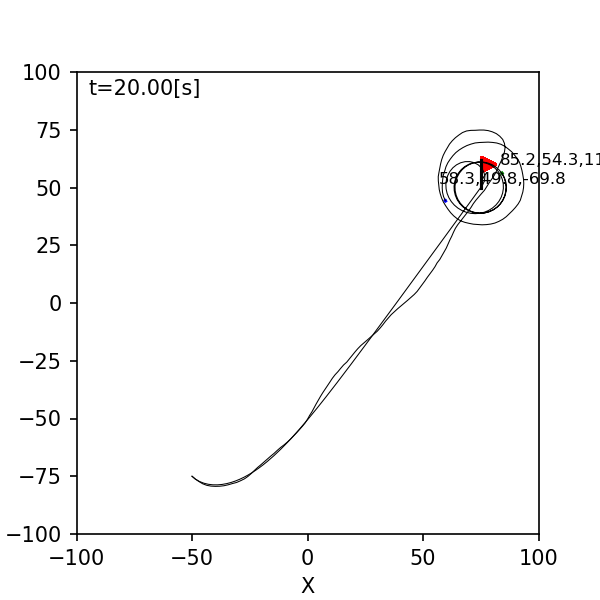

In [4]:
if __name__ == "__main__":    #ライブラリとして読み込む場合は実行しない  
    class Agent2(Agent):    #Agentクラスから継承し，新たなエージェントを定義
        def __init__(self, goal_pos=[0, 0]):
            super().__init__()    #親クラスから継承
            self.goal_pos = goal_pos    #ゴール座標

        def action(self, pose):    #actionメソッドをオーバーライド
            kp = 0.01    #比例ゲイン
            direction = math.atan2(self.goal_pos[1] - pose[1], self.goal_pos[0] - pose[0])*180/math.pi    #ゴールの方角
            rover_dir = pose[2]*180/math.pi    #ローバーの向いている方角
            deltaTheta = ((540 + direction - rover_dir) % 360) - 180    #ローバーの向いている方角とゴールの向いている方角の差
            mPF = 10    #モータ前進成分
            mPS = kp * deltaTheta    #モータ回転成分
            mPL = mPF - mPS    #左モータパワー
            mPR = mPF + mPS    #右モータパワー
            
            #モータパワーの絶対値をを100以下にする
            #エージェントクラスにも同じ処理が実装されているが，それは制約を実装したもの
            #下のコードは誤った入力による事故を防止するための実装
            mPL = 100 if mPL > 100 else mPL
            mPR = 100 if mPR > 100 else mPR
            mPL = -100 if mPL < -100 else mPL
            mPR = -100 if mPR < -100 else mPR
            
            self.motor(mPL, mPR)    #モータの駆動（ローバーの移動速度が自動的に計算される）
            #with open("data.txt", "a") as f:    #計算値をファイルに保存（デバッグ用）
            #    f.write("{} {} {} {} {} {}\n".format(direction, rover_dir, deltaTheta, mPS, mPL, mPR))
            return self.nu, self.omega    #ローバーの移動速度を返す
    
    time_finish = 20    #シミュレーション終了時間
    time_interval = 0.1    #ステップ時間
    goal = [75, 50]    #ゴールの座標
    map_size = [100, 100]
    
    world = World(
        time_finish,    #シミュレーション終了時間
        time_interval,    #ステップ時間
        debug=False,    #デバッグモードか検証モードか
        map_size=map_size,    #地図サイズ
        goal_pos=goal    #ゴール座標
    )    #地図の実装

    agent1 = Agent(motor=[0, 0])
    agent2 = Agent2(goal)

    robot1 = Robot(
        np.array([-50, -75, -math.pi/4]).T,    ##初期位置，姿勢
        agent=agent2,    #ローバーが従うエージェント
        sensor=Sensor(time_interval=time_interval),   #ローバーに搭載されているセンサ
        color="blue",    #ローバの色（描画上の設定）
        #noise_per_meter=0,
        #bias_rate_stds=(0, 0)
    )    #ロボットの実装
    
    robot2 = IdealRobot(
        np.array([-50, -75, -math.pi/4]).T,    ##初期位置，姿勢
        agent=agent2,    #ローバーが従うエージェント
        sensor=IdealSensor(),   #ローバーに搭載されているセンサ
        color="green",    #ローバの色（描画上の設定）
        #noise_per_meter=0,
        #bias_rate_stds=(0, 0)
    )    #ロボットの実装
    
    world.append(robot1)    #世界地図にローバーを組み込む
    world.append(robot2)
    world.draw()    #世界地図の描画